In [1]:
import numpy as np
import os 
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from openpyxl import Workbook

import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [27]:
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.facecolor'] = 'white' 

In [2]:
def write_dict_to_excel(data_dict, filename):
    workbook = Workbook()

    worksheet = workbook.active

    headers = list(data_dict.keys())
    worksheet.append(headers)

    values = list(data_dict.values())
    worksheet.append(values)

    workbook.save(filename)

In [3]:
df_reward = pd.read_excel('reward_quest.xlsx')
df_punish = pd.read_excel('punishment_quest.xlsx')
df_mixed = pd.read_excel('mixed_quest.xlsx')
df_p_memory1 = pd.read_csv('punishment_memory_summary.csv')
df_r_memory1 = pd.read_csv('reward_memory_summary.csv')
df_m_memory1 = pd.read_csv('mixed_memory_summary.csv')
df_hddm_m = pd.read_csv('mixed_hddm_stats.csv')
df_hddm_r = pd.read_csv('reward_hddm_stats.csv')
df_hddm_p = pd.read_csv('punish_hddm_stats.csv')

In [4]:
df_p_memory1['rt'] = pd.to_numeric(df_p_memory1['rt'], errors='coerce')
df_p_memory1 = df_p_memory1.dropna(subset=['rt'])
df_r_memory1['rt'] = pd.to_numeric(df_r_memory1['rt'], errors='coerce')
df_r_memory1 = df_r_memory1.dropna(subset=['rt'])
df_m_memory1['rt'] = pd.to_numeric(df_m_memory1['rt'], errors='coerce')
df_m_memory1 = df_m_memory1.dropna(subset=['rt'])

df_m_memory1['meta'] = 1 - (df_m_memory1['accuracy'] - df_m_memory1['confidence']/100)**2
df_r_memory1['meta'] = 1 - (df_r_memory1['accuracy'] - df_r_memory1['confidence']/100)**2
df_p_memory1['meta'] = 1 - (df_p_memory1['accuracy'] - df_p_memory1['confidence']/100)**2

In [5]:
df_r_memory = df_r_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    accuracy=('accuracy', 'mean'),
    confidence=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    rt=('rt', 'mean')
).reset_index()

df_m_memory = df_m_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    accuracy=('accuracy', 'mean'),
    confidence=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    rt=('rt', 'mean')
).reset_index()

df_p_memory = df_p_memory1.groupby(['subject_nr', 'menu', 'stage', 'condition']).agg(
    accuracy=('accuracy', 'mean'),
    confidence=('confidence', 'mean'),
    meta=('meta', 'mean'),
    AUC=('AUC', 'mean'),
    rt=('rt', 'mean')
).reset_index()

In [6]:
sub_list_reward = df_r_memory['subject_nr'].unique()
cond_list_reward = df_r_memory['condition'].unique()
stage_list_reward = df_r_memory['stage'].unique()

sub_list_punishment = df_p_memory['subject_nr'].unique()
cond_list_punishment = df_p_memory['condition'].unique()
stage_list_punishment = df_p_memory['stage'].unique()

sub_list_mixed = df_m_memory['subject_nr'].unique()
cond_list_mixed= df_m_memory['condition'].unique()
stage_list_mixed= df_m_memory['stage'].unique()

In [7]:
df_hddm_m.rename(columns={'Unnamed: 0':'V1'}, inplace=True)
df_hddm_r.rename(columns={'Unnamed: 0':'V1'}, inplace=True)
df_hddm_p.rename(columns={'Unnamed: 0':'V1'}, inplace=True)

In [8]:
def get_hddm_para(ddm_results,subList):
    v_former_diff = ddm_results[ddm_results['V1'].str.contains("v_former_diff_subj")][['mean', 'V1']].reset_index(drop=True)
    v_ses = ddm_results[ddm_results['V1'].str.contains("v_ses_subj")][['mean', 'V1']].reset_index(drop=True)
    v_former_diff_ses = ddm_results[ddm_results['V1'].str.contains("v_former_diff:ses_subj")][['mean', 'V1']].reset_index(drop=True)
    v_diff = ddm_results[ddm_results['V1'].str.contains("v_diff_subj")][['mean', 'V1']].reset_index(drop=True)
    v_diff_ses = ddm_results[ddm_results['V1'].str.contains("v_diff:ses_subj")][['mean', 'V1']].reset_index(drop=True)
    a_ses = ddm_results[ddm_results['V1'].str.contains("a_ses_subj")][['mean', 'V1']].reset_index(drop=True)
    z_ses = ddm_results[ddm_results['V1'].str.contains("z_ses_subj")][['mean', 'V1']].reset_index(drop=True)

    # Combine the data
    ddm_params = pd.concat([
        v_former_diff[['mean']], 
        v_ses[['mean']], 
        v_former_diff_ses[['mean']], 
        v_diff[['mean']], 
        v_diff_ses[['mean']], 
        a_ses[['mean']], 
        z_ses[['mean']]
    ], axis=1)

    # Rename the columns
    ddm_params.columns = ['v_former_diff', 'v_ses', 'v_former_diff_ses', 'v_diff', 'v_diff_ses', 'a_ses', 'z_ses']

    # Add the subList as a new column
    ddm_params['subjno'] = subList
    
    return ddm_params

In [9]:
hddm_para_mixed = get_hddm_para(df_hddm_m,sub_list_mixed)
hddm_para_reward = get_hddm_para(df_hddm_r,sub_list_reward)
hddm_para_punish = get_hddm_para(df_hddm_p,sub_list_punishment)
parameter_list = hddm_para_mixed.columns.tolist()

In [10]:
col_name_list_p = df_punish.columns.tolist()
col_name_list_m = df_mixed.columns.tolist()
col_name_list_r = df_reward.columns.tolist()
reward_emotion_list = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42]
punish_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]
mixed_emotion_list = [26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48]


calculate the matrix with the emotion, lie rate and hddm parameter

In [11]:
color_list = ['#70309f','#e7b13e','#2a74a3','#c66236','#00FFFF']
emotion_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Positive_Sum','Negative_Sum','Total']

In [12]:
data_punish = np.zeros([len(sub_list_punishment), len(emotion_list)])

for i in range(len(sub_list_punishment)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_punish[i,j] = df_punish[col_nn][df_punish.iloc[:, 6] == sub_list_punishment[i]].to_numpy()[0]
        
data_reward = np.zeros([len(sub_list_reward), len(emotion_list)])

for i in range(len(sub_list_reward)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_reward[i,j] = df_reward[col_nn][df_reward.iloc[:, 1] == sub_list_reward[i]].to_numpy()[0] 
        
data_mixed = np.zeros([len(sub_list_mixed), len(emotion_list)])

for i in range(len(sub_list_mixed)):
    for j in range(len(emotion_list)):
        col_nn = col_name_list_p[punish_emotion_list[j]]
        data_mixed[i,j] = df_mixed[col_nn][df_mixed.iloc[:, 6] == sub_list_mixed[i]].to_numpy()[0]

In [13]:
column_list = ['Interested','Distressed','Excited','Upset','Strong','Guilty','Scared','Hostile','Enthusiastic','Proud','Irritable','Alert','Ashamed','Inspired','Nervous','Determined','Attentive','Jittery','Active','Afraid','Pos','Neg','Total']
df_punish_emo = pd.DataFrame(data_punish, columns=column_list)
df_reward_emo = pd.DataFrame(data_reward, columns=column_list)
df_mixed_emo = pd.DataFrame(data_mixed, columns=column_list)

In [14]:
combined_df_punish = pd.concat([df_punish_emo, hddm_para_punish], axis=1)
combined_df_punish = combined_df_punish.drop(columns='subjno')

combined_df_reward = pd.concat([df_reward_emo, hddm_para_reward], axis=1)
combined_df_reward = combined_df_reward.drop(columns='subjno')

combined_df_mixed = pd.concat([df_mixed_emo, hddm_para_mixed], axis=1)
combined_df_mixed = combined_df_mixed.drop(columns='subjno')

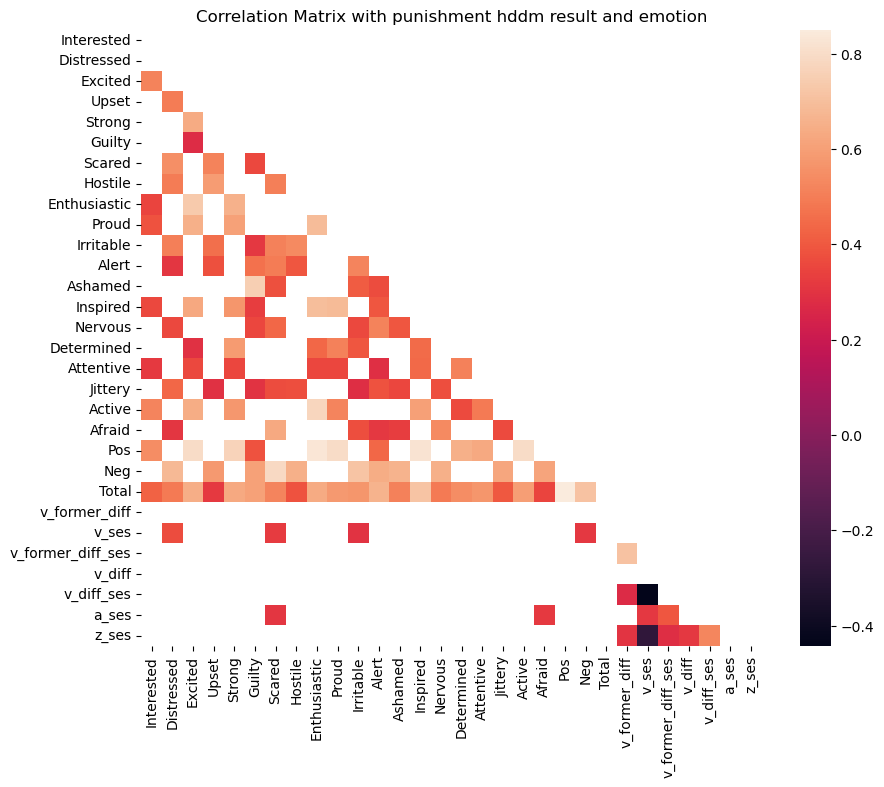

In [28]:
corr = combined_df_punish.corr()
p_matrix = np.zeros_like(corr)
for i in range(len(corr)):
    for j in range(len(corr)):
        _, p_matrix[i, j] = pearsonr(combined_df_punish.iloc[:, i], combined_df_punish.iloc[:, j])

alpha = 0.05
mask_significant = p_matrix >= alpha
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
custom_colors = ["blue", "white", "red"]
sns.heatmap(corr, mask=mask | mask_significant)
plt.title('Correlation Matrix with punishment hddm result and emotion')
plt.show()

In [16]:
p_value_matrix_p = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_pvalue_p = p_value_matrix_p.applymap(lambda x: round(x, 4))
corr_value_p = combined_df_punish.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_40888\2316489347.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pvalue_p = p_value_matrix_p.applymap(lambda x: round(x, 4))


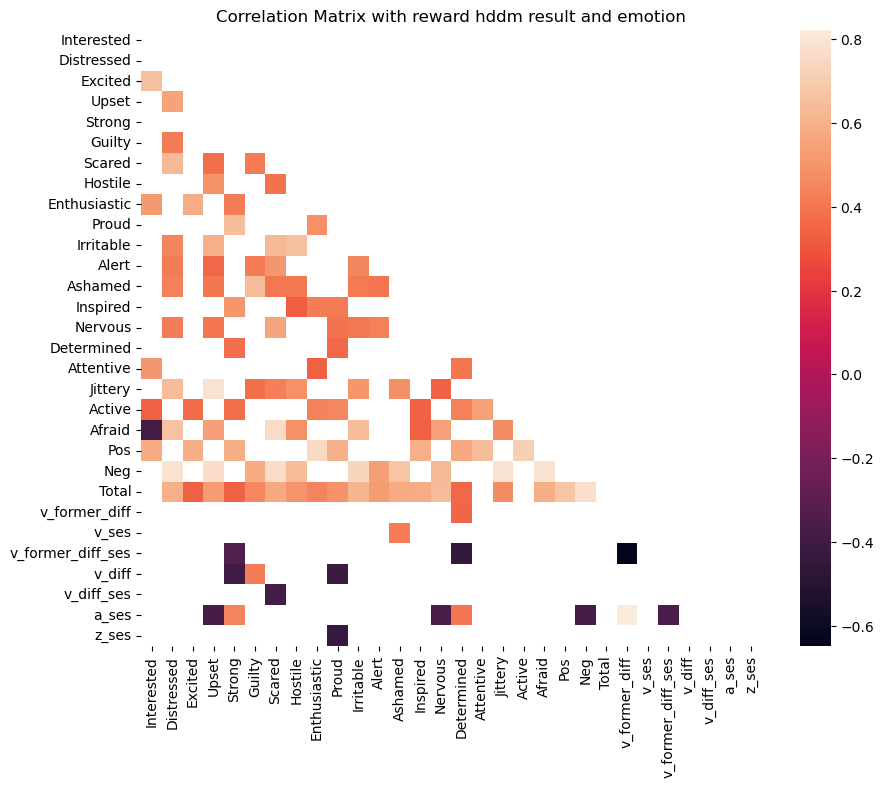

In [29]:
corr = combined_df_reward.corr()
p_matrix = np.zeros_like(corr)
for i in range(len(corr)):
    for j in range(len(corr)):
        _, p_matrix[i, j] = pearsonr(combined_df_reward.iloc[:, i], combined_df_reward.iloc[:, j])

alpha = 0.05
mask_significant = p_matrix >= alpha
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
custom_colors = ["blue", "white", "red"]
sns.heatmap(corr, mask=mask | mask_significant)
plt.title('Correlation Matrix with reward hddm result and emotion')
plt.show()

In [18]:
p_value_matrix_r = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_pvalue_r = p_value_matrix_r.applymap(lambda x: round(x, 4))
corr_value_r = combined_df_reward.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_40888\3292015793.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pvalue_r = p_value_matrix_r.applymap(lambda x: round(x, 4))


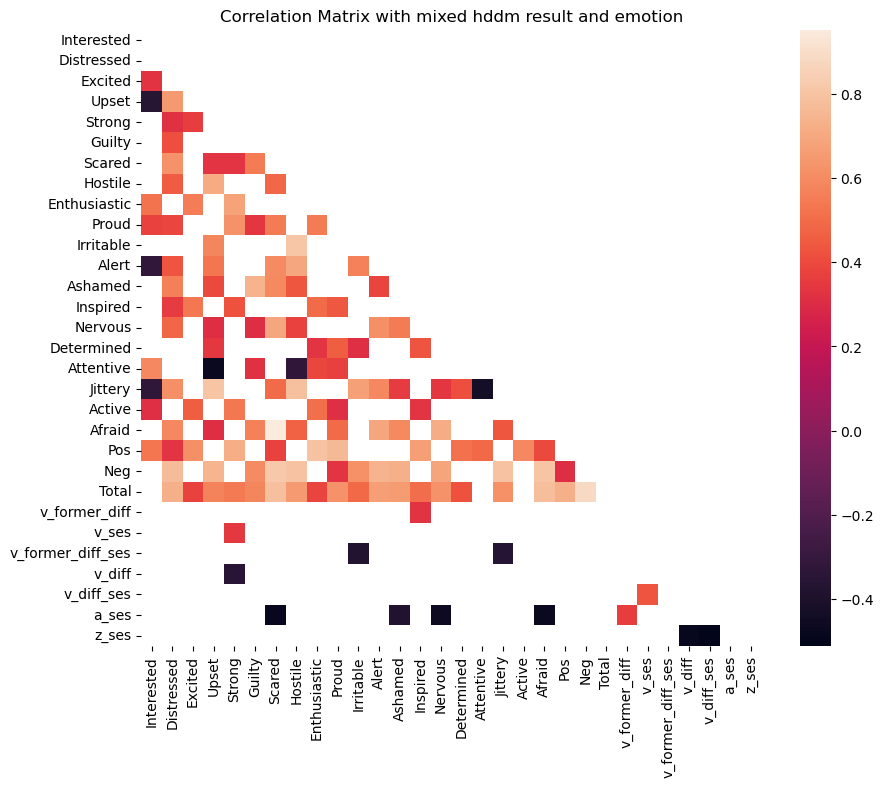

In [30]:
corr = combined_df_mixed.corr()
p_matrix = np.zeros_like(corr)
for i in range(len(corr)):
    for j in range(len(corr)):
        _, p_matrix[i, j] = pearsonr(combined_df_mixed.iloc[:, i], combined_df_mixed.iloc[:, j])

alpha = 0.05
mask_significant = p_matrix >= alpha
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
custom_colors = ["blue", "white", "red"]
sns.heatmap(corr, mask=mask | mask_significant)
plt.title('Correlation Matrix with mixed hddm result and emotion')
plt.show()

In [20]:
p_value_matrix_m = pd.DataFrame(p_matrix, index=corr.index, columns=corr.columns)
df_pvalue_m = p_value_matrix_m.applymap(lambda x: round(x, 4))
corr_value_m = combined_df_mixed.corr()

C:\Users\18611\AppData\Local\Temp\ipykernel_40888\877543574.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_pvalue_m = p_value_matrix_m.applymap(lambda x: round(x, 4))


In [21]:
file_path = "hddm_pvalue.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    df_pvalue_r.to_excel(writer, sheet_name='reward', index=False)
    df_pvalue_p.to_excel(writer, sheet_name='punish', index=False)
    df_pvalue_m.to_excel(writer, sheet_name='mixed', index=False)

In [22]:
file_path = "hddm_corr_value.xlsx"

# Save DataFrames to different sheets
with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
    corr_value_r.to_excel(writer, sheet_name='reward', index=False)
    corr_value_p.to_excel(writer, sheet_name='punish', index=False)
    corr_value_m.to_excel(writer, sheet_name='mixed', index=False)

Plot the correlation for the matrix

In [31]:
def plot_correlation(df, col1, col2):
    """
    Plots a scatter plot with a regression line for the correlation between two columns in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col1 (str): The name of the first column.
    col2 (str): The name of the second column.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=col1, y=col2, color='blue', alpha=0.6, s=50)
    sns.regplot(data=df, x=col1, y=col2, scatter=False, color='red', line_kws={"linewidth": 2})
    
    plt.title(f'Correlation between {col1} and {col2}', fontsize=16)
    plt.xlabel(col1, fontsize=12)
    plt.ylabel(col2, fontsize=12)
    plt.grid(True)
    plt.show()

In [ ]:
plot_correlation(combined_df_reward, 'Interested', 'auc_drop')